In [388]:
import sys
sys.path.append("..")

import Essentials
import Visualizer_pred

In [389]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [390]:
data_archive = np.load('../Data_Average_Nikita.npz', allow_pickle=True)

In [391]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [392]:
ALL_column_names_1 = data_archive['column_names_1'] 
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat'] 
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

column_names_2 = data_archive['column_names_2']
x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

column_names_3 = data_archive['column_names_3']
x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

In [393]:
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.25, random_state=10)

In [394]:
all_X_1.shape

(107, 87)

In [395]:
y_train, timestamp_train = prepare_Y(y_train)

In [396]:
y_test, timestamp_test = prepare_Y(y_test)

In [397]:
x_train.shape

(80, 87)

In [398]:
x_test.shape

(27, 87)

In [399]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_2, y_winter_half_2, test_size=0.2, random_state=10)

In [400]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_2, y_summer_half_2, test_size=0.2, random_state=10)

In [401]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [402]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [403]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [404]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [405]:
class PCA_LR(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train):
        super().__init__(name)
        self.x_scaler = StandardScaler()
        self.x_pca = None  # Инициализация будет в методе tune_pca_components
        self.fit_scaler(x_train)

        # Поиск оптимального количества компонент
        self.tune_pca_components(x_train, y_train)

        # Обучение модели
        self.model = LinearRegression()
        self.train(x_train, y_train)
        self.set_model(self.model)

    def tune_pca_components(self, x_train, y_train):
        r2_scores = []
        for n_components in range(1, 40):
            pca = PCA(n_components=n_components)
            self.fit_pca(pca, x_train)
            pca_x_train = self.preprocessing(x_train)

            # Обучение модели на обучающей выборке с текущим количеством компонент
            model = LinearRegression()
            model.fit(pca_x_train, y_train)

            # Предсказание на обучающей выборке
            y_pred_train = model.predict(pca_x_train)

            # Расчёт R^2 на обучающей выборке и обновление списка r2_scores
            r2 = r2_score(y_train, y_pred_train)
            r2_scores.append(r2)

        # Определение числа компонент с максимальным R^2 на обучающей выборке
        optimal_n_components = np.argmax(r2_scores) + 1
        print(f"Оптимальное количество главных компонент (на основе обучающей выборки): {optimal_n_components}")

        # Обучение PCA с оптимальным числом компонент
        self.x_pca = PCA(n_components=optimal_n_components)
        self.x_pca.fit(self.x_scaler.transform(x_train))
    
    def preprocessing(self, x):
        try:
            x_scaled = self.x_scaler.transform(x)
            return self.x_pca.transform(x_scaled)
        except BaseException as err:
            print("Ошибка скейлера")
            raise err    
    
    def postprocessing(self, x):
        return x

    def fit_scaler(self, x):
        self.x_scaler.fit(x)

    def fit_pca(self, pca, x):
        scaled_x = self.x_scaler.transform(x)
        pca.fit(scaled_x)
        self.x_pca = pca
    
    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions

    def train(self, x_train, y_train):
        pca_x = self.preprocessing(x_train)
        self.model.fit(pca_x,y_train)

    def __str__(self):
        # Описание главных компонент как линейных комбинаций исходных переменных
        pcs_descriptions = []
        for i, pc in enumerate(self.x_pca.components_):
            pc_terms = [f"{weight:.4f}*x{j+1}" for j, weight in enumerate(pc)]
            pcs_formula = " + ".join(pc_terms)
            pcs_descriptions.append(f"PC{i+1}:")
            pcs_descriptions.append(pcs_formula)
            pcs_descriptions.append("-" * 40)  # Горизонтальный разделитель
    
        # Формируем итоговую строку
        complete_str = "\n".join(pcs_descriptions) if pcs_descriptions else "Нет компонент для отображения."
        
        return complete_str

In [406]:
PCA_LR_test = PCA_LR("PCA_LR" ,x_train ,y_train)

Оптимальное количество главных компонент (на основе обучающей выборки): 39


In [407]:
metric = Essentials.R2Metric()

In [408]:
print(PCA_LR_test)

PC1:
0.1657*x1 + -0.0126*x2 + -0.0086*x3 + 0.0936*x4 + 0.1681*x5 + -0.0181*x6 + 0.1026*x7 + 0.0924*x8 + 0.0913*x9 + 0.1550*x10 + 0.0924*x11 + 0.0053*x12 + 0.1405*x13 + 0.1614*x14 + 0.1660*x15 + 0.1086*x16 + 0.1371*x17 + -0.1454*x18 + 0.0969*x19 + 0.0635*x20 + 0.1421*x21 + 0.1459*x22 + 0.0476*x23 + -0.1087*x24 + 0.1648*x25 + -0.0037*x26 + 0.0981*x27 + -0.0117*x28 + 0.0382*x29 + 0.1657*x30 + 0.1665*x31 + 0.0025*x32 + 0.0525*x33 + 0.0320*x34 + 0.0209*x35 + -0.0041*x36 + 0.0081*x37 + 0.0506*x38 + 0.0969*x39 + 0.1558*x40 + 0.1485*x41 + 0.1569*x42 + 0.1614*x43 + 0.1311*x44 + 0.1492*x45 + 0.1706*x46 + 0.1569*x47 + 0.1700*x48 + 0.1459*x49 + 0.1702*x50 + 0.1466*x51 + 0.1684*x52 + 0.1433*x53 + 0.0164*x54 + 0.1667*x55 + 0.1664*x56 + 0.1185*x57 + -0.0122*x58 + 0.0885*x59 + -0.0112*x60 + 0.0316*x61 + -0.0510*x62 + 0.0159*x63 + 0.0179*x64 + 0.0289*x65 + 0.0325*x66 + 0.0763*x67 + -0.0525*x68 + 0.0285*x69 + 0.0740*x70 + 0.0559*x71 + -0.0603*x72 + -0.0233*x73 + 0.1642*x74 + 0.1650*x75 + 0.0265*x76 + 0.

In [409]:
PCA_LR_test.test(x_test, y_test, metric)

(array([[61.19422525],
        [58.95708631],
        [60.56341706],
        [49.57773445],
        [60.54021113],
        [55.86400297],
        [58.54827602],
        [59.50117944],
        [55.31950763],
        [56.18816479],
        [59.78914381],
        [54.32939874],
        [58.97595958],
        [53.77873971],
        [65.71341916],
        [59.48693236],
        [51.16242242],
        [59.43977913],
        [56.46272005],
        [51.19797821],
        [62.78884032],
        [56.46590279],
        [57.66490539],
        [52.76050327],
        [54.04295932],
        [56.45482241],
        [49.40398946]]),
 0.7399151831161259)

In [410]:
test_visual=Visualizer_pred.Visualizer(x_test, y_test, timestamp_test, [metric], 'Linear with PCA SoftSensor R2 and MSE metric on Test')

+--------+--------------------------------+---------+
|        |   Coefficient of determination |     MSE |
+========+================================+=========+
| PCA_LR |                       0.739915 | 4.39491 |
+--------+--------------------------------+---------+


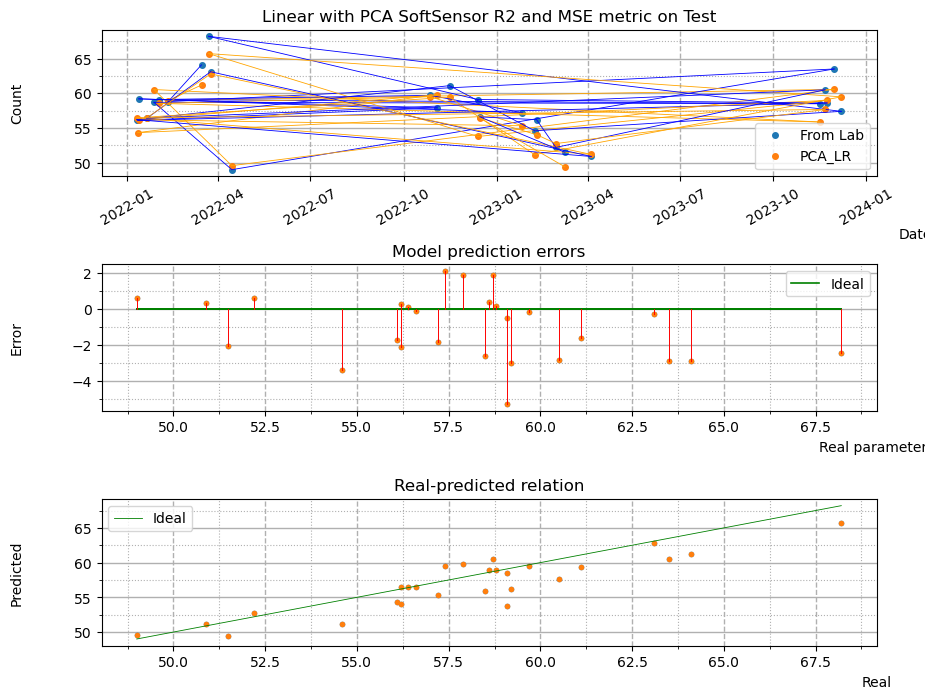

In [411]:
test_visual.visualize([PCA_LR_test], lines=True, lines_vertical=True)